In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
import torch
import torch.nn as nn
from torchsummary import summary
import model
from utils import evaluate_psnr, compute_psnr

In [180]:
from importlib import reload
reload(model);

## Load data

In [5]:
# Load train data
TRAIN_PATH = '../../data/train_data.pkl'
train_noisy_imgs_input, train_noisy_imgs_target = torch.load(TRAIN_PATH)
print('training size: ', train_noisy_imgs_input.shape[0])
training_set_size, num_channels, y_size, x_size = train_noisy_imgs_input.shape

training size:  50000


In [6]:
# Load validation data
VALIDATION_PATH = '../../data/val_data.pkl'
validation_noisy_imgs, validation_clean_imgs = torch.load(VALIDATION_PATH)
print('validation size: ', validation_clean_imgs.shape[0])

validation size:  1000


## Torch implementation

In [8]:
class TorchModel():
    def __init__(self, **kwargs):
        self.model = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid()
            )
        self.criterion = nn.MSELoss()

        optimizer = kwargs.get('optimizer', 'Adam')
        if(optimizer == 'Adam'):
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        elif(optimizer == 'SGD'):
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1)
        else:
            raise ValueError('Optimizer not implemented')

    def load_pretrained_model(self):
        ## This loads the parameters saved in bestmodel.pth into the model
        self.model = torch.load('bestmodel.pth')

    def train(self, train_input, train_target, num_epochs, **kwargs):
        # train ̇input: tensor of size (N, C, H, W) containing a noisy version of the images.
        # train target: tensor of size (N, C, H, W) containing another noisy version of the
        # same images, which only differs from the input by their noise.
        train_input = train_input / 255.0
        train_target = train_target / 255.0
        batch_size = kwargs.get('batch_size', 32)
        self.losses = []
        
        for e in range(num_epochs):
            print('Doing epoch %d'%e)
            avg_loss = 0
            for b, (input, target) in enumerate(zip(train_input.split(batch_size),
                                                    train_target.split(batch_size))):
                output = self.model(input)
                loss = self.criterion(output, target)
                avg_loss += loss.item()

                # make step
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                b_freq = 5
                if b % b_freq == 0 and b > 0:
                    self.losses.append(avg_loss / b_freq)
                    avg_loss = 0
                    b % 50 == 0 and kwargs.get('debug', False) and print(self.losses[-1])

    def predict(self, test_input):
        #:test ̇input: tensor of size (N1, C, H, W) that has to be denoised by the trained
        # or the loaded network.
        #: returns a tensor of the size (N1, C, H, W)
        output = self.model(test_input / 255.0) * 255.0
        return output.to(test_input.dtype)

In [ ]:
summary(TorchModel().model, (3, 32, 32))

## Training

In [10]:
if not(os.path.exists('models')):
    os.mkdir('models')

In [11]:
def set_model(model_name):
  if (model_name=='Ours'):
    torch.set_grad_enabled(False)
    net = model.Model(optimizer='Adam')
  elif (model_name=='Ours_SGD'):
    torch.set_grad_enabled(False)
    net = model.Model(optimizer='SGD')
  elif (model_name=='Torch'):
    torch.set_grad_enabled(True)
    net = TorchModel(optimizer='Adam')
  elif (model_name=='Torch_SGD'):
    torch.set_grad_enabled(True)
    net = TorchModel(optimizer='SGD')
  else:
    raise ValueError('Invalid model name!')

  return net

In [78]:
# model_name = 'Ours'
# model_name = 'Ours_SGD'
model_name = 'Torch'
# model_name = 'Torch_SGD'

In [79]:
nb_epochs = 10

train_start_time_ms = time.perf_counter()
net = set_model(model_name)
net.train(train_noisy_imgs_input, train_noisy_imgs_target, nb_epochs, debug=True)
train_end_time_ms = time.perf_counter()
training_time = train_end_time_ms - train_start_time_ms
print('Training took: ', training_time, 's')

# Save model
if model_name in ['Torch', 'Torch_SGD']:
    checkpoint = {'model': net.model.state_dict(),
                'optimizer' : net.optimizer.state_dict(),
                'losses' : net.losses
                }
    torch.save(checkpoint, 'models/' + model_name + '.pth')
else:
    checkpoint = {'conv0.weight': net.model.layers[0].weight,
                  'conv0.bias': net.model.layers[0].bias,
                  'conv1.weight': net.model.layers[2].weight,
                  'conv1.bias': net.model.layers[2].bias,
                  'conv2.weight': net.model.layers[4].layers[1].weight,
                  'conv2.bias': net.model.layers[4].layers[1].bias,
                  'conv3.weight': net.model.layers[6].layers[1].weight,
                  'conv3.bias': net.model.layers[6].layers[1].bias,
                  'losses' : net.losses
                }
              
    torch.save(checkpoint, 'models/' + model_name + '.pth')
    with open('models/' + model_name + '.pkl', 'wb') as fs:
        pickle.dump(checkpoint, fs)

Doing epoch 0
0.05430290177464485
0.031315311416983606
0.027877488732337953
0.03488968685269356
0.023481899127364158
0.024586441367864607
0.021892310678958894
0.02382773272693157
0.024148104712367058
0.023271695896983146
0.02358210235834122
0.02214490473270416
0.02230711579322815
0.023244300857186317
0.021636183187365533
0.021952316537499426
0.01890541911125183
0.021904076635837554
0.021857523918151857
0.02185522988438606
0.021690736711025237
0.02645999751985073
0.021706653386354448
0.019657015800476074
0.01998904123902321
0.020326317101716996
0.021058596298098566
0.01903124526143074
0.019306008145213126
0.02224608026444912
0.021574675291776656
Doing epoch 1
0.018864569813013078
0.020209886506199835
0.019278741255402566
0.021153921633958815
0.017054746113717555
0.021020795032382012
0.018545490875840186
0.02093719020485878
0.020494336634874342
0.019617226719856263
0.02073852941393852
0.020804386213421823
0.01914455331861973
0.020774729177355768
0.01889710407704115
0.01993423476815224
0.

## Evaluation

In [12]:
if not(os.path.exists('figures')):
    os.mkdir('figures')

In [13]:
def load_model(model_name, model_path):
    if (model_name=='Ours'):
        net = model.Model(optimizer='Adam')
    elif (model_name=='Ours_SGD'):
        net = model.Model(optimizer='SGD')
    elif (model_name=='Torch'):
        net = TorchModel(optimizer='Adam')
    elif (model_name=='Torch_SGD'):
        net = TorchModel(optimizer='SGD')
    else:
        raise ValueError('Invalid model name!')

    if model_name in ['Torch', 'Torch_SGD']:
        checkpoint = torch.load(model_path)
        net.model.load_state_dict(checkpoint['model'])
    else:
        checkpoint = torch.load(model_path)
        # with open(model_path, 'wb') as fs:
        #     checkpoint = pickle.load(checkpoint, fs)
        net.model.layers[0].weight = checkpoint['conv0.weight']
        net.model.layers[0].bias = checkpoint['conv0.bias']
        net.model.layers[2].weight = checkpoint['conv1.weight']
        net.model.layers[2].bias = checkpoint['conv1.bias']
        net.model.layers[4].layers[1].weight = checkpoint['conv2.weight']
        net.model.layers[4].layers[1].bias = checkpoint['conv2.bias']
        net.model.layers[6].layers[1].weight = checkpoint['conv3.weight']
        net.model.layers[6].layers[1].bias = checkpoint['conv3.bias']
    net.losses = checkpoint['losses']
    return net

In [220]:
model_name = 'Ours'
# model_name = 'Ours_SGD'
# model_name = 'Torch'
# model_name = 'Torch_SGD'
net = load_model(model_name, model_path='models/' + model_name + '.pth')

In [218]:
evaluate_psnr(net, validation_noisy_imgs, validation_clean_imgs)

tensor(22.8533)

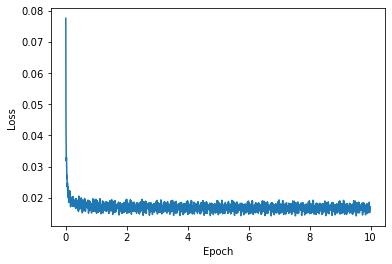

In [72]:
fig = plt.figure()
xs = np.arange(len(net.losses)) / train_noisy_imgs_input.shape[0] * 32 * 5
plt.plot(xs, net.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

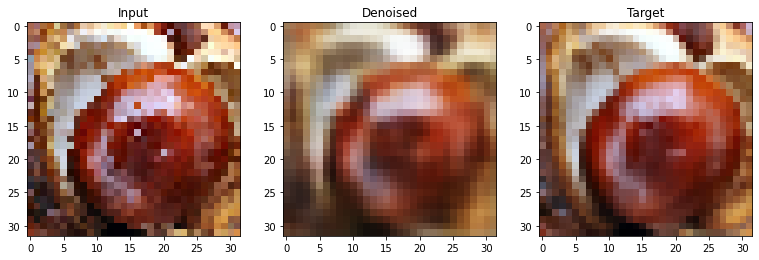

In [66]:
test_input = validation_noisy_imgs
test_target = validation_clean_imgs

nr = 3
denoised = net.predict(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Denoised')
ax[2].imshow(test_target[nr, :, :, :].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Target')
plt.show()

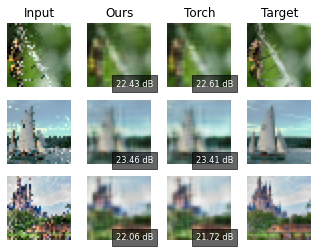

In [229]:
# Visualize predictions
example_image_nrs = [10, 732, 880] # These are three beautiful example images
nr_example_images = 3
model_list = ['Ours', 'Torch']
model_paths = ['models/' + model_name + '.pth' for model_name in model_list] 

fig, ax = plt.subplots(nr_example_images, len(model_list)+2, figsize=(5.5, 4))
random_nrs = torch.randint(validation_noisy_imgs.shape[0], size=(1, nr_example_images))

for m in range(len(model_list)):
  net = load_model(model_list[m], model_paths[m])
  for i in range(nr_example_images):
    nr = example_image_nrs[i]
    denoised = net.predict(validation_noisy_imgs[nr, :, :, :].unsqueeze(dim=0))
    dB = compute_psnr(denoised / 255, validation_clean_imgs[nr, :, :, :].unsqueeze(0) / 255)

    ax[i, m+1].imshow(denoised[0, :, :, :].permute(1, 2, 0).detach().cpu() / 255)
    (i==0) and ax[i,m+1].set_title(model_list[m])
    ax[i, m+1].axis('off')
    ax[i, m+1].text(23, 30,f'%.2f dB'%(dB.item()), ha='center', va='center', 
                   color='w', backgroundcolor='k', fontsize='small',
                   bbox=dict(alpha=0.6, color='k'))

    if (m==0):
      ax[i, 0].imshow(validation_noisy_imgs[nr, :, :, :].permute(1, 2, 0).cpu())
      (i==0) and ax[i, 0].set_title('Input')
      ax[i, 0].axis('off')

      ax[i, len(model_list)+1].imshow(validation_clean_imgs[nr, :, :, :].permute(1, 2, 0).cpu())
      (i==0) and ax[i, len(model_list)+1].set_title('Target')
      ax[i, len(model_list)+1].axis('off')

fig.savefig('figures/example_outputs.pdf', bbox_inches='tight')

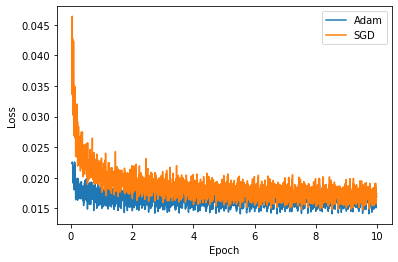

In [101]:
Ours_net = load_model('Ours', model_path='models/' + 'Ours' + '.pth')
OursSGD_net = load_model('Ours_SGD', model_path='models/' + 'Ours_SGD' + '.pth')
Torch_net = load_model('Torch', model_path='models/' + 'Torch' + '.pth')
TorchSGD_net = load_model('Torch_SGD', model_path='models/' + 'Torch_SGD' + '.pth')


fig = plt.figure()
xs = np.arange(len(Ours_net.losses)) / train_noisy_imgs_input.shape[0] * 32 * 5
n = 13
plt.plot(xs[n:], Ours_net.losses[n:], xs[n:], OursSGD_net.losses[n:])
plt.legend(['Adam', 'SGD'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

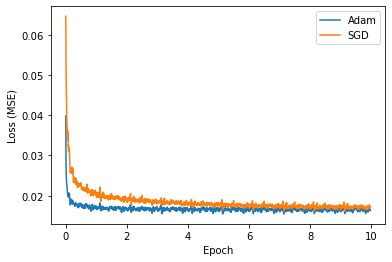

In [125]:
N = 8
adamloss = np.convolve(Ours_net.losses, np.ones(N)/N, mode='valid')
sgdloss = np.convolve(OursSGD_net.losses, np.ones(N)/N, mode='valid')
xs = np.arange(len(adamloss)) / train_noisy_imgs_input.shape[0] * 32 * 5
n = 0
plt.plot(xs[n:], adamloss[n:], xs[n:], sgdloss[n:])
plt.legend(['Adam', 'SGD'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.savefig('figures/losses.pdf', bbox_inches='tight', pad_inches=0)